In [23]:
import json
import os
import re
from matplotlib import pyplot as plt
from collections import Counter
from nltk import tokenize
from nltk.corpus import stopwords
from tqdm import trange

In [24]:
def word_count(text):
    text_words = text.split()
    return len(text_words)


def preprocess_data(directory):
    all_texts, categories, keywords, places = [], [], [], []
    for filename in os.listdir(directory):
        with open(directory + filename, "r") as file:
            data = json.load(file)
            for news in data:
                if "text" in news:
                    if "lede" in news:
                        all_texts.append(news["lede"] + ' ' + news["text"])
                    else:
                        all_texts.append(news["text"])
                    categories.append(news["categories"])
                    keywords.append(news["keywords"])
                    places.append(news["places"])
                elif "lede" in news:
                    all_texts.append(news["lede"])
                    categories.append(news["categories"])
                    keywords.append(news["keywords"])
                    places.append(news["places"])
    return all_texts, categories, keywords, places


def calculate_text_stats(all_texts):
    stats = {
        "lengths": [len(news) for news in all_texts],
        "word_counts": [word_count(news) for news in all_texts],
        "sent_counts": [len(tokenize.sent_tokenize(news)) for news in all_texts]
    }
    stats["mean_word_lengths"] = [stats["lengths"][i] / stats["word_counts"][i] for i in range(len(all_texts))]
    stats["mean_sent_lengths"] = [stats["lengths"][i] / stats["sent_counts"][i] for i in range(len(all_texts))]
    return stats


def create_plots(stats, language="sl", show=False, dpi=150):
    plt.ioff()
    lengths = stats["lengths"]
    one_bin = 1000
    bins = [one_bin * i for i in range(int(max(lengths) // one_bin) + 2)]
    fig = plt.figure()
    plt.hist(lengths, bins=bins, color='orange', edgecolor='black', linewidth=1)
    plt.savefig("figures/" + language + "_lengths_hist.jpg", dpi=dpi)
    if show:
        plt.title("Lengths, " + language)
        plt.show()
    plt.close(fig)
        
    word_counts = stats["word_counts"]
    one_bin = 100
    bins = [one_bin * i for i in range(int(max(word_counts) // one_bin) + 2)]
    fig = plt.figure()
    plt.hist(word_counts, bins=bins, color='orange', edgecolor='black', linewidth=1)
    plt.savefig("figures/" + language + "_word_counts_hist.jpg", dpi=dpi)
    if show:
        plt.title("Word counts, " + language)
        plt.show()
    plt.close(fig)
        
    sent_counts = stats["sent_counts"]
    one_bin = 5
    bins = [one_bin * i for i in range(int(max(sent_counts) // one_bin) + 2)]
    fig = plt.figure()
    plt.hist(sent_counts, bins=bins, color='orange', edgecolor='black', linewidth=1)
    plt.savefig("figures/" + language + "_sent_counts_hist.jpg", dpi=dpi)
    if show:
        plt.title("Sent counts, " + language)
        plt.show()
    plt.close(fig)
    
    mean_word_lengths = stats["mean_word_lengths"]
    one_bin = 0.5
    bins = [one_bin * i for i in range(int(min(mean_word_lengths) // one_bin), int(max(mean_word_lengths) // one_bin) + 2)]
    fig = plt.figure()
    plt.hist(mean_word_lengths, bins=bins, color='orange', edgecolor='black', linewidth=1)
    plt.savefig("figures/" + language + "_mean_word_lengths_hist.jpg", dpi=dpi)
    if show:
        plt.title("Mean word lengths, " + language)
        plt.show()
    plt.close(fig)
        
    mean_sent_lengths = stats["mean_sent_lengths"]
    one_bin = 150
    bins = [one_bin * i for i in range(int(min(mean_sent_lengths) // one_bin), int(max(mean_sent_lengths) // one_bin) + 2)]
    fig = plt.figure()
    plt.hist(mean_sent_lengths, bins=bins, color='orange', edgecolor='black', linewidth=1)
    plt.savefig("figures/" + language + "_mean_sent_lengths_hist.jpg", dpi=dpi)
    if show:
        plt.title("Mean sent lengths, " + language)
        plt.show()
    plt.close(fig)
    
    
def clean_text(text, language="sl"):
    text = text.lower()
    if language == "sl":
        text = re.sub('[^a-z 0-9čšž]+', '', text)
        text = " ".join([word for word in text.split() if word not in stopwords.words('slovene')])
    elif language == "en":
        text = re.sub('[^a-z 0-9]+', '', text)
        text = " ".join([word for word in text.split() if word not in stopwords.words('english')])
    else:
        raise Exception(f"Language {language} not supported")
    return text


def count_n_most_common_words(words, n=15):
    most_common = Counter(words).most_common(len(words))
    common_words, freq = [], []
    added_commons = 0
    for word, count in most_common:
        if word.isdigit() or word == '-':
            continue
        common_words.append(word)
        freq.append(count)
        added_commons += 1
        if added_commons >= n:
            break
    return common_words, freq
    
    
def count_n_most_common_keywords(keywords_lists, n=15):
    most_commons = dict()
    for i in range(len(keywords_lists)):
        for keyword in keywords_lists[i]:
            if keyword not in most_commons:
                most_commons[keyword] = 1
            else:
                most_commons[keyword] += 1
    common_keywords, freq = [], []
    added_commons = 0
    for keyword, count in dict(sorted(most_commons.items(), key=lambda item: -item[1])).items():
        common_keywords.append(keyword)
        freq.append(count)
        added_commons += 1
        if added_commons >= n:
            break
    return common_keywords, freq
    
    
def count_n_most_common_places(places_list, type_of_place="city, country", n=15):
    most_commons = dict()
    for i in range(len(places_list)):
        unique_places_from_news = []
        for place in places_list[i]:
            if type_of_place == "city, country":
                news_place = place["city"] + ", " + place["country"]
            else:
                news_place = place[type_of_place]
            if news_place in unique_places_from_news:
                continue
            unique_places_from_news.append(news_place)
            if news_place not in most_commons:
                most_commons[news_place] = 1
            else:
                most_commons[news_place] += 1
    common_places, freq = [], []
    added_commons = 0
    for keyword, count in dict(sorted(most_commons.items(), key=lambda item: -item[1])).items():
        common_places.append(keyword)
        freq.append(count)
        added_commons += 1
        if added_commons >= n:
            break
    return common_places, freq


def plot_commons(commons, freq, name, language="sl", show=False, dpi=150):
    plt.ioff()
    fig = plt.figure()
    plt.barh(commons[::-1], freq[::-1], color='orange', edgecolor='black', linewidth=1)
    plt.savefig("figures/" + language + '_' + name + "_bar.jpg", bbox_inches="tight", dpi=dpi)
    if show:
        plt.show()
    plt.close(fig)

# EDA

The EDA is done with data downloaded from 2 months (September and October 2023). It contains 1912 English and 12852 Slovenian news.

## English news

We start EDA with EN language as we focus on this language for the 1st part of the project.

In [25]:
language = "en"
all_texts, categories, keywords, places = preprocess_data("../data_preparation/raw_data/" + language + '/')
texts_stats = calculate_text_stats(all_texts)

First, we examine the distribution of article lengths. To do this, we count all characters, no matter if they are whitespace characters or letters. Belowe we can see obtained results. Most of the articles have no more than 4000 characters. We can observe the peak for number of news between 1000 and 2000 characters - there are exactly 671 such news.

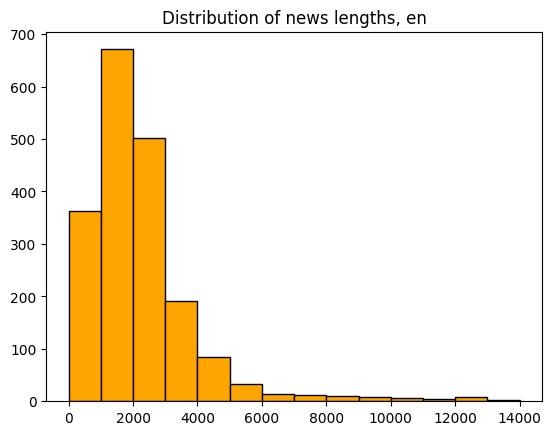

In [26]:
lengths = texts_stats["lengths"]
one_bin = 1000
bins = [one_bin * i for i in range(int(max(lengths) // one_bin) + 2)]
fig = plt.figure()
plt.hist(lengths, bins=bins, color='orange', edgecolor='black', linewidth=1)
plt.title("Distribution of news lengths, " + language)
plt.show()

Then, we examine the distribution of number of used words in the news. More than 85% of English news has less than 500 words, but there are some outliers in the data.


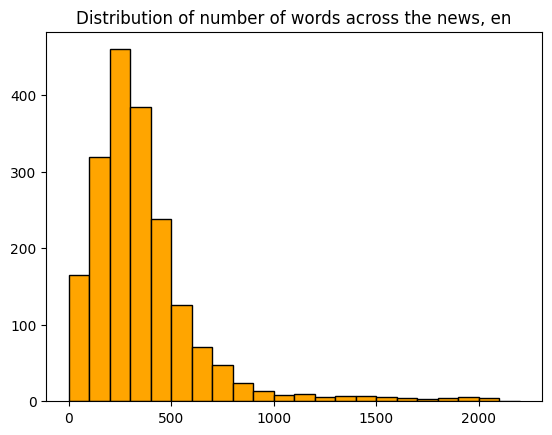

In [27]:
word_counts = texts_stats["word_counts"]
one_bin = 100
bins = [one_bin * i for i in range(int(max(word_counts) // one_bin) + 2)]
fig = plt.figure()
plt.hist(word_counts, bins=bins, color='orange', edgecolor='black', linewidth=1)
plt.title("Distribution of number of words across the news, " + language)
plt.show()

Next, we do the same but instead of words we count sentences. The distribution is very similar to that for the words. More than 90% of the news had less than 30 sentences.

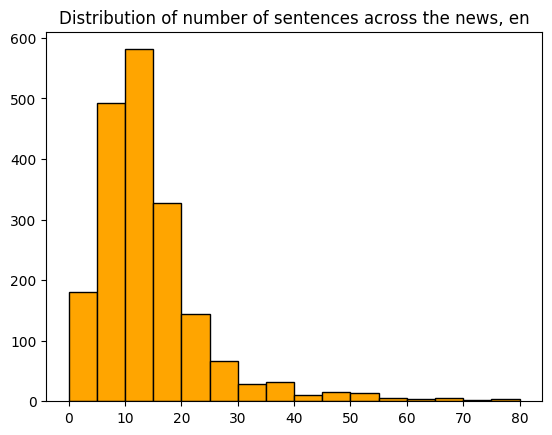

In [28]:
sent_counts = texts_stats["sent_counts"]
one_bin = 5
bins = [one_bin * i for i in range(int(max(sent_counts) // one_bin) + 2)]
fig = plt.figure()
plt.hist(sent_counts, bins=bins, color='orange', edgecolor='black', linewidth=1)
plt.title("Distribution of number of sentences across the news, " + language)
plt.show()

Here, we check the distribution of mean word lengths across the news. We can see that most of the news contains words that on average have from 6 fo 7 characters.

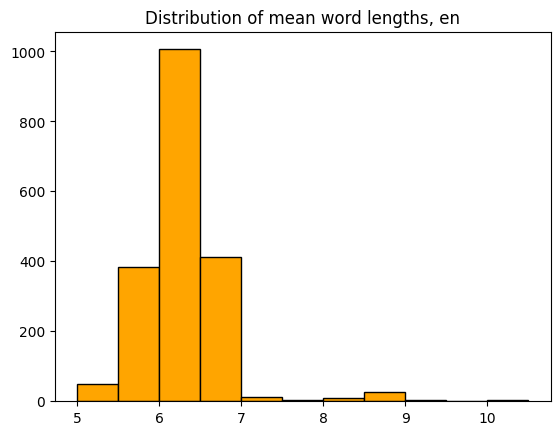

In [29]:
mean_word_lengths = texts_stats["mean_word_lengths"]
one_bin = 0.5
bins = [one_bin * i for i in range(int(min(mean_word_lengths) // one_bin), int(max(mean_word_lengths) // one_bin) + 2)]
fig = plt.figure()
plt.hist(mean_word_lengths, bins=bins, color='orange', edgecolor='black', linewidth=1)
plt.title("Distribution of mean word lengths, " + language)
plt.show()

We can also check similar distribution, but with counting average number of characters in sentence. The figure shows that most of the news have sentences that on average have from 100 to 200 characters. 

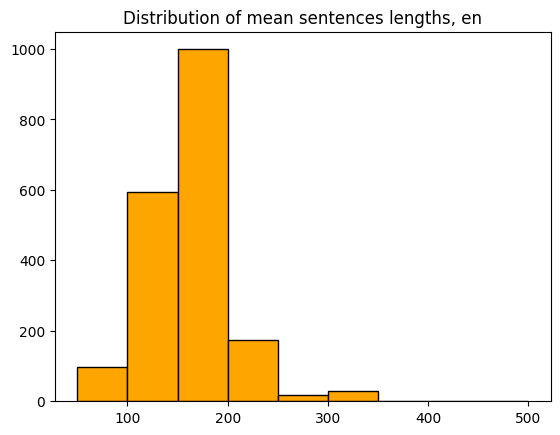

In [30]:
mean_sent_lengths = texts_stats["mean_sent_lengths"]
one_bin = 50
bins = [one_bin * i for i in range(int(min(mean_sent_lengths) // one_bin), int(max(mean_sent_lengths) // one_bin) + 2)]
fig = plt.figure()
plt.hist(mean_sent_lengths, bins=bins, color='orange', edgecolor='black', linewidth=1)
plt.title("Distribution of mean sentences lengths, " + language)
plt.show()

Next, we focus on contents of the news, which means most common words, categories of news, and keywords related to them. To do this, we clean our data by removing all characters except letters, numbers and spaces. We do not need other characters to count specific words. Then, we delete stopwords from the news.

In [31]:
all_used_words = []
for i in trange(len(all_texts), ncols=100, nrows=10, colour='green', smoothing=0.8):
    cleaned_text = clean_text(all_texts[i], language=language)
    all_used_words += cleaned_text.split()

100%|███████████████████████████████████████████████████████████| 1912/1912 [01:39<00:00, 19.21it/s]


Firstly, we check which words appear the most in the news (except removed stopwords) and "the winners" are said, Slovenia, Slovenian, also, minister, eur, and government. These show what most news can be about - about Slovenia and politics.

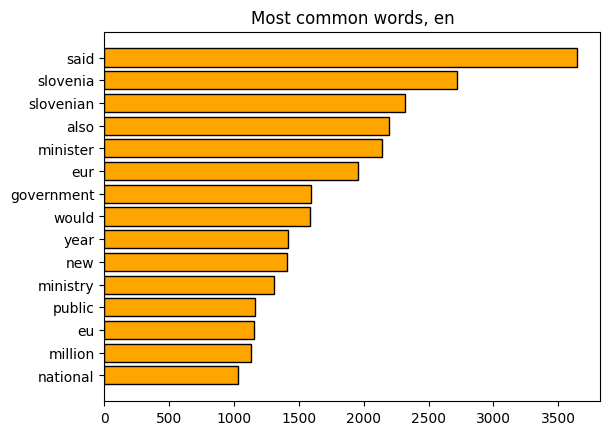

In [32]:
words, freq = count_n_most_common_words(all_used_words, n=15)
fig = plt.figure()
plt.barh(words[::-1], freq[::-1], color='orange', edgecolor='black', linewidth=1)
plt.title("Most common words, " + language)
plt.show()

We check most common categories of the news. Most news is in PO (Politics), BE (Business, Finance and Economy), and AS (Around Slovenia) categories.

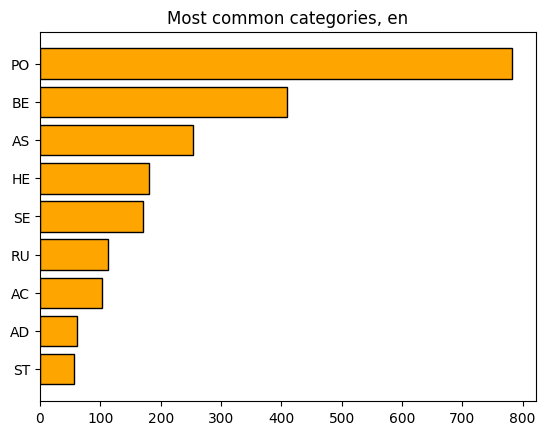

In [33]:
common_keywords, freq = count_n_most_common_keywords(categories)
fig = plt.figure()
plt.barh(common_keywords[::-1], freq[::-1], color='orange', edgecolor='black', linewidth=1)
plt.title("Most common categories, " + language)
plt.show()

Then, we check how often every keyword appears in the news.

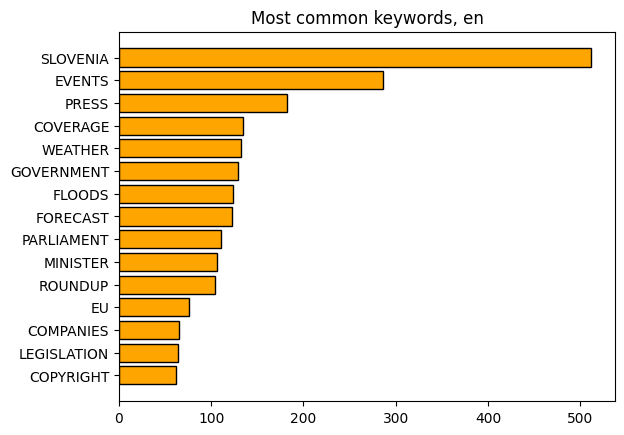

In [34]:
common_keywords, freq = count_n_most_common_keywords(keywords)
fig = plt.figure()
plt.barh(common_keywords[::-1], freq[::-1], color='orange', edgecolor='black', linewidth=1)
plt.title("Most common keywords, " + language)
plt.show()

Here, we check how much news concerns the country. Clearly, most news concerns Slovenia.

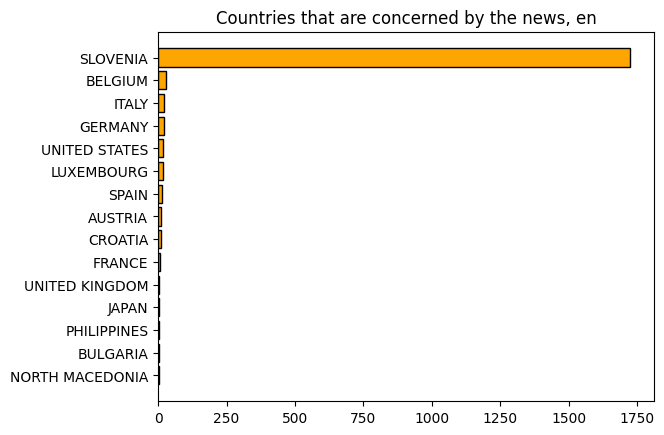

In [35]:
common_places, freq = count_n_most_common_places(places, type_of_place="country", n=15)
fig = plt.figure()
plt.barh(common_places[::-1], freq[::-1], color='orange', edgecolor='black', linewidth=1)
plt.title("Countries that are concerned by the news, " + language)
plt.show()

We also check how much news is about a particular city. We can see that first three cities are Slovenian.

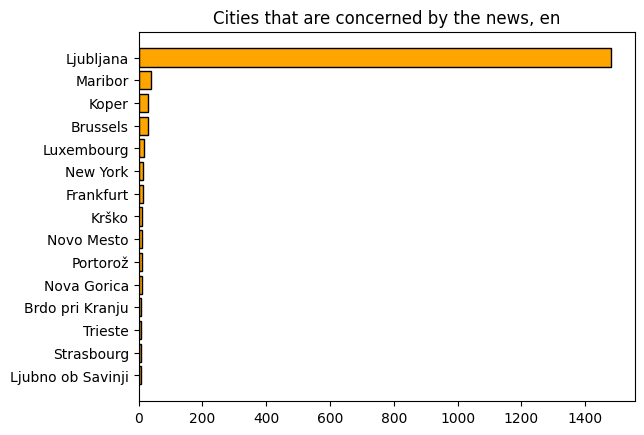

In [36]:
common_places, freq = count_n_most_common_places(places, type_of_place="city", n=15)
fig = plt.figure()
plt.barh(common_places[::-1], freq[::-1], color='orange', edgecolor='black', linewidth=1)
plt.title("Cities that are concerned by the news, " + language)
plt.show()

## Slovenian news

Here, we plot the same statistic for Slovenian news. Because in the first part of the project we do not focus on the Slovenian news, we do not comment the plots here. However, some comments can be found in the project report.

In [37]:
language = "sl"
all_texts, categories, keywords, places = preprocess_data("../data_preparation/raw_data/" + language + '/')
texts_stats = calculate_text_stats(all_texts)

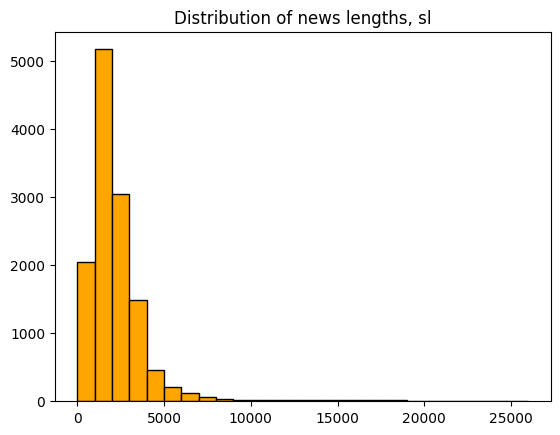

In [38]:
lengths = texts_stats["lengths"]
one_bin = 1000
bins = [one_bin * i for i in range(int(max(lengths) // one_bin) + 2)]
fig = plt.figure()
plt.hist(lengths, bins=bins, color='orange', edgecolor='black', linewidth=1)
plt.title("Distribution of news lengths, " + language)
plt.show()

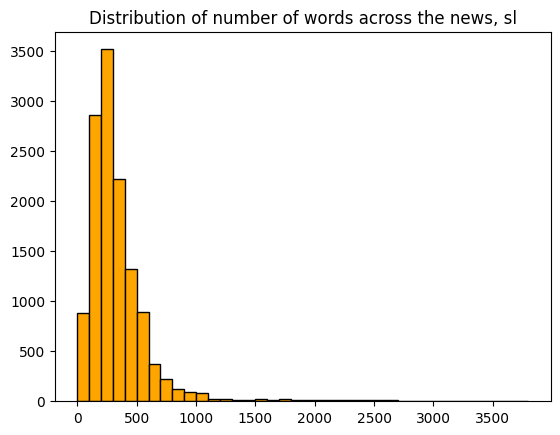

In [39]:
word_counts = texts_stats["word_counts"]
one_bin = 100
bins = [one_bin * i for i in range(int(max(word_counts) // one_bin) + 2)]
fig = plt.figure()
plt.hist(word_counts, bins=bins, color='orange', edgecolor='black', linewidth=1)
plt.title("Distribution of number of words across the news, " + language)
plt.show()

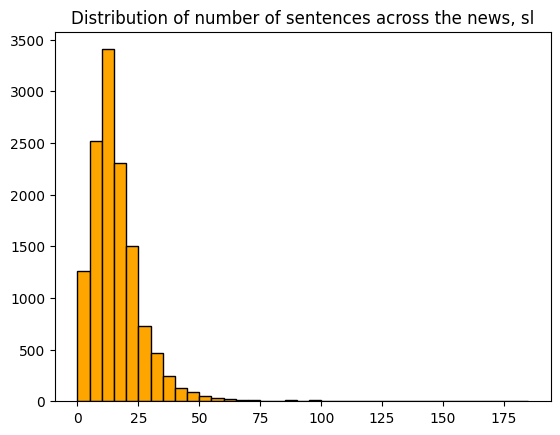

In [40]:
sent_counts = texts_stats["sent_counts"]
one_bin = 5
bins = [one_bin * i for i in range(int(max(sent_counts) // one_bin) + 2)]
fig = plt.figure()
plt.hist(sent_counts, bins=bins, color='orange', edgecolor='black', linewidth=1)
plt.title("Distribution of number of sentences across the news, " + language)
plt.show()

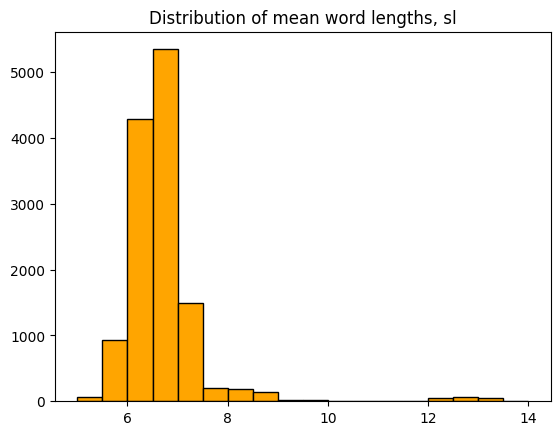

In [41]:
mean_word_lengths = texts_stats["mean_word_lengths"]
one_bin = 0.5
bins = [one_bin * i for i in range(int(min(mean_word_lengths) // one_bin), int(max(mean_word_lengths) // one_bin) + 2)]
fig = plt.figure()
plt.hist(mean_word_lengths, bins=bins, color='orange', edgecolor='black', linewidth=1)
plt.title("Distribution of mean word lengths, " + language)
plt.show()

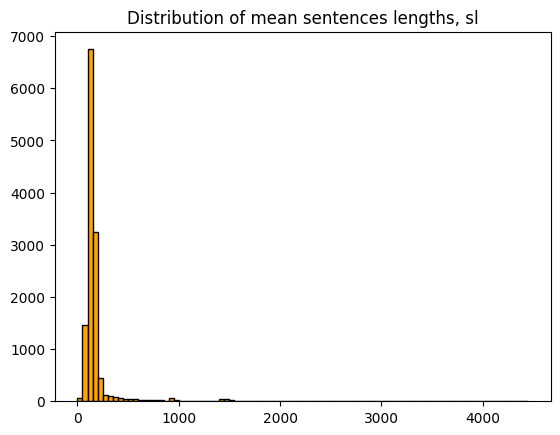

In [42]:
mean_sent_lengths = texts_stats["mean_sent_lengths"]
one_bin = 50
bins = [one_bin * i for i in range(int(min(mean_sent_lengths) // one_bin), int(max(mean_sent_lengths) // one_bin) + 2)]
fig = plt.figure()
plt.hist(mean_sent_lengths, bins=bins, color='orange', edgecolor='black', linewidth=1)
plt.title("Distribution of mean sentences lengths, " + language)
plt.show()

In [43]:
all_used_words = []
for i in trange(len(all_texts), ncols=100, nrows=10, colour='green', smoothing=0.8):
    cleaned_text = clean_text(all_texts[i], language=language)
    all_used_words += cleaned_text.split()

100%|█████████████████████████████████████████████████████████| 12852/12852 [50:13<00:00,  4.26it/s]


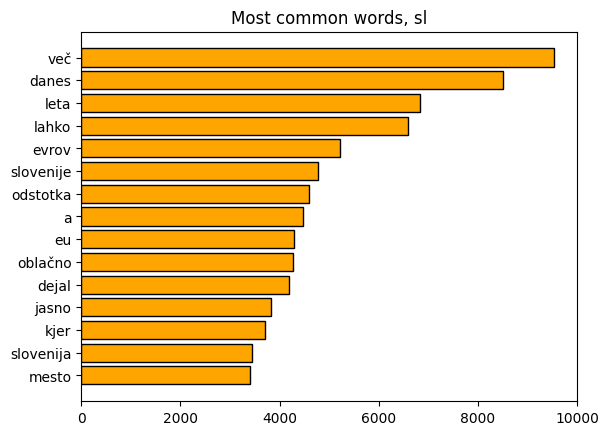

In [44]:
words, freq = count_n_most_common_words(all_used_words, n=15)
fig = plt.figure()
plt.barh(words[::-1], freq[::-1], color='orange', edgecolor='black', linewidth=1)
plt.title("Most common words, " + language)
plt.show()

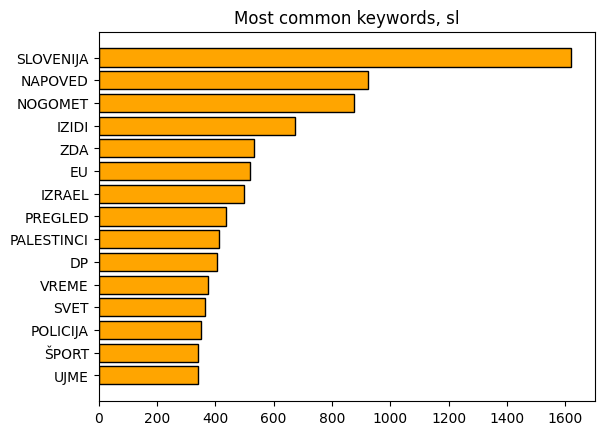

In [45]:
common_keywords, freq = count_n_most_common_keywords(keywords)
fig = plt.figure()
plt.barh(common_keywords[::-1], freq[::-1], color='orange', edgecolor='black', linewidth=1)
plt.title("Most common keywords, " + language)
plt.show()

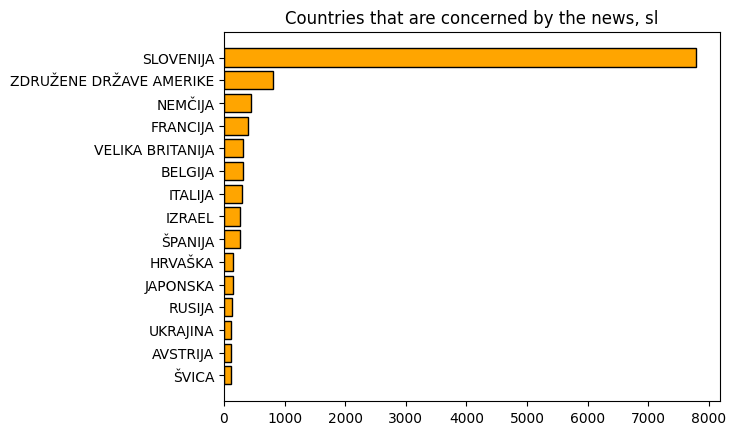

In [46]:
common_places, freq = count_n_most_common_places(places, type_of_place="country", n=15)
fig = plt.figure()
plt.barh(common_places[::-1], freq[::-1], color='orange', edgecolor='black', linewidth=1)
plt.title("Countries that are concerned by the news, " + language)
plt.show()

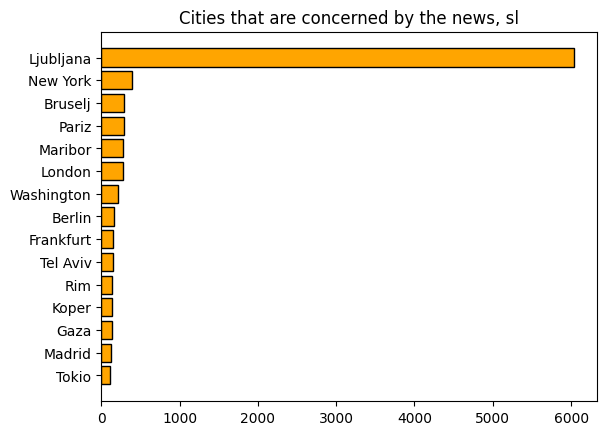

In [47]:
common_places, freq = count_n_most_common_places(places, type_of_place="city", n=15)
fig = plt.figure()
plt.barh(common_places[::-1], freq[::-1], color='orange', edgecolor='black', linewidth=1)
plt.title("Cities that are concerned by the news, " + language)
plt.show()

### Generating plots in EDA/figures directory
Run this code only if you want to generate files with plots (for example for report).

In [48]:
for language in ["sl", "en"]:
    all_texts, categories, keywords, places = preprocess_data("../data_preparation/raw_data/" + language + '/')
    texts_stats = calculate_text_stats(all_texts)
    create_plots(texts_stats, language=language, show=False)
    all_used_words = []
    for i in trange(len(all_texts), ncols=100, nrows=10, colour='green', smoothing=0.8):
        cleaned_text = clean_text(all_texts[i], language=language)
        all_used_words += cleaned_text.split()
    words, freq = count_n_most_common_words(all_used_words, n=15)
    plot_commons(words, freq, name="most_common_words", language=language, show=False)
    common_keywords, freq = count_n_most_common_keywords(keywords)
    plot_commons(common_keywords, freq, name="most_common_keywords", language=language, show=False)
    common_places, freq = count_n_most_common_places(places, type_of_place="city, country", n=15)
    plot_commons(common_places, freq, name="most_common_cities_countries", language=language, show=False)
    common_places, freq = count_n_most_common_places(places, type_of_place="country", n=15)
    plot_commons(common_places, freq, name="most_common_countries", language=language, show=False)
    common_places, freq = count_n_most_common_places(places, type_of_place="city", n=15)
    plot_commons(common_places, freq, name="most_common_cities", language=language, show=False)

100%|███████████████████████████████████████████████████████████| 1912/1912 [01:30<00:00, 21.16it/s]
